# This is a notebook for SVM, training a model to be able to categorize fake vs real news

In [3]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Load the data formating it correctly for easy use.

In [4]:
# Load the datasets formating them correctly for ease of use
train_data = pd.read_csv(
    r"../training_data_lowercase.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

test_data = pd.read_csv(
    r"../testing_data_lowercase_nolabels.csv",
    sep='\t',  # TAB separator
    header=None,
    names=['label', 'title']
)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


Apply TF-IDF to the dataset to conver the words into numerical values for model training

In [5]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(train_data['title'])
y = train_data['label']


print("\nTF-IDF Feature Names:", tfidf_vectorizer.get_feature_names_out())
print("\nTF-IDF Representation:\n", X_tfidf)


TF-IDF Feature Names: ['00' '0045' '0111' ... 'îk' 'îpence' 'øqu']

TF-IDF Representation:
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 390264 stored elements and shape (34152, 18673)>
  Coords	Values
  (0, 5341)	0.23594607631008147
  (0, 17168)	0.09871680270440454
  (0, 14809)	0.360810448061762
  (0, 11760)	0.2251642878332491
  (0, 5782)	0.36784073721965305
  (0, 11261)	0.21081145630832848
  (0, 18556)	0.2795008715924424
  (0, 6110)	0.41238633616840253
  (0, 10595)	0.31514400469546994
  (0, 16720)	0.22142744799533873
  (0, 9017)	0.18273121389310565
  (0, 5242)	0.3795171214730221
  (1, 17168)	0.10035834003226096
  (1, 5514)	0.4328255787960555
  (1, 2371)	0.42168063909640197
  (1, 15785)	0.3923235418466126
  (1, 15837)	0.3982062340521523
  (1, 14360)	0.26389760407113516
  (1, 3525)	0.38008086220062226
  (1, 8953)	0.3133469115315427
  (2, 14997)	0.27978598468001187
  (2, 4445)	0.30178363237263756
  (2, 3325)	0.3361754376926148
  (2, 1830)	0.3090971771169678
  (2, 985)	

Train and evaluation the Model

In [6]:
# TF-IDF Vectorization (Only fit on training data)
tfidf_vectorizer = TfidfVectorizer()
X_train_val, X_test, y_train_val, y_test = train_test_split(train_data['title'], train_data['label'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Fit vectorizer only on training data
tfidf_vectorizer.fit(X_train)

# Transform all datasets consistently
X_train = tfidf_vectorizer.transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)
X_test = tfidf_vectorizer.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred = svm_model.predict(X_val)
y_test_pred = svm_model.predict(X_test)

# Evaluate the model
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred)}")
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print(f"Validation R²: {r2_score(y_val, y_val_pred)}")

print("\n" + "-"*50 + "\n")

print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test R²: {r2_score(y_test, y_test_pred)}")

Validation Accuracy: 0.9433465085638999
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      3510
           1       0.94      0.95      0.94      3321

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831

Validation R²: 0.7732124244319365

--------------------------------------------------

Test Accuracy: 0.9462743375786854
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      3529
           1       0.94      0.95      0.95      3302

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831

Test R²: 0.784859773111224


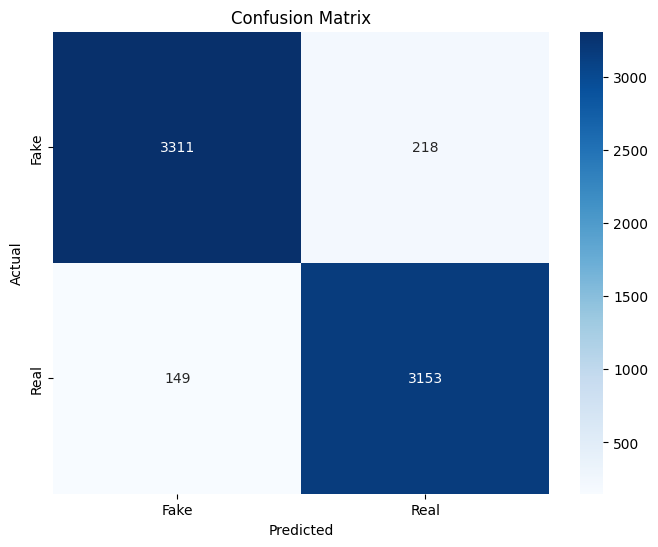

In [7]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Predict labels for the testing data and write them on a csv file

In [8]:
X_test_unlabeled = tfidf_vectorizer.transform(test_data['title'])

# Predict labels for the unlabeled data
predicted_labels = svm_model.predict(X_test_unlabeled)
test_data['label'] = predicted_labels
print(test_data.head())

   label                                              title
0      0  copycat muslim terrorist arrested with assault...
1      0  wow! chicago protester caught on camera admits...
2      1   germany's fdp look to fill schaeuble's big shoes
3      0  mi school sends welcome back packet warning ki...
4      1  u.n. seeks 'massive' aid boost amid rohingya '...


In [9]:
# Make sure title is string, not list
test_data['title'] = test_data['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Export respecting original format
test_data[['label', 'title']].to_csv(
    r'svm_test_data.csv',
    sep='\t',  # TAB separator
    index=False,
    header=False  # No column names
)
print("\n:white_check_mark: Predictions exported successfully in correct format!")


:white_check_mark: Predictions exported successfully in correct format!
